# Lab 03.b - Week 4
# Time Series Processing
## Using CWT and deep neural networks for a time series classification task

In this task, you will be using accelerometer data. This is signal data used to determine what state someone is in, i.e walking, running etc. For this, we will be utilising CWT to help achieve accurate classification using some basic deep learning models.

In [1]:
!pip install PyWavelets -q
!pip install matplotlib
!pip install seaborn
!pip install tensorflow
!pip install scikit-learn
!pip install scikit-image
!pip install xgboost
!pip install opencv-python
!pip install tensorflow-metal

In [23]:
import tensorflow as tf
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)



Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
# All Includes
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.decomposition import PCA
import xgboost as xgb

from skimage.transform import resize

from sklearn.metrics import confusion_matrix

import pywt

import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
#import keras (high level API) wiht tensorflow as backend
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

TensorFlow version: 2.18.0


The below code cells are util functions and cells to load the dataset for this lab. Please ensure that you have access to the data. The dataset is available on SurreyLearn so please downloaded it and adjust path variable as needed.

*Note*: if you are using Google Colab please upload the dataset to your Google Drive.

In [3]:
def load_y_data(y_path):
    y = np.loadtxt(y_path, dtype=np.int32).reshape(-1,1)
    # change labels range from 1-6 t 0-5, this enables a sparse_categorical_crossentropy loss function
    return y - 1

def load_X_data(X_path):
    X_signal_paths = [X_path + file for file in os.listdir(X_path)]
    X_signals = [np.loadtxt(path, dtype=np.float32) for path in X_signal_paths]
    return np.transpose(np.array(X_signals), (1, 2, 0))

In [4]:
#Upload dataset to google drive if using google colab and mount
#If using Jupyter ensure notebook has access and adjust path as needed
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
#adjust path as needed
PATH = './Dataset/UCI HAR Dataset/'
LABEL_NAMES = ["Walking", "Walking upstairs", "Walking downstairs", "Sitting", "Standing", "Laying"]

# load X data
X_train = load_X_data(PATH + 'train/Inertial Signals/')
X_test = load_X_data(PATH + 'test/Inertial Signals/')
# load y label
y_train = load_y_data(PATH + 'train/y_train.txt')
y_test = load_y_data(PATH + 'test/y_test.txt')

print("useful information:")
print(f"shapes (n_samples, n_steps, n_signals) of X_train: {X_train.shape} and X_test: {X_test.shape}")
X_all = np.concatenate([X_train, X_test])
print(f"all X's have following mean: {format(X_all.mean(), '.2f')} and standard deviation: {format(X_all.std(), '.2f')} ")

useful information:
shapes (n_samples, n_steps, n_signals) of X_train: (7352, 128, 9) and X_test: (2947, 128, 9)
all X's have following mean: 0.10 and standard deviation: 0.40 


Here we split the labels of the dataset into a list for easy access

In [6]:
def split_indices_per_label(y):
    indicies_per_label = [[] for x in range(0,6)]
    # loop over the six labels
    for i in range(6):
        indicies_per_label[i] = np.where(y == i)[0]
    return indicies_per_label

# list of list of sample indicies per activity
train_labels_indicies = split_indices_per_label(y_train)

Here we are performing CWT on the dataset and plotting an exaple of each class in the data

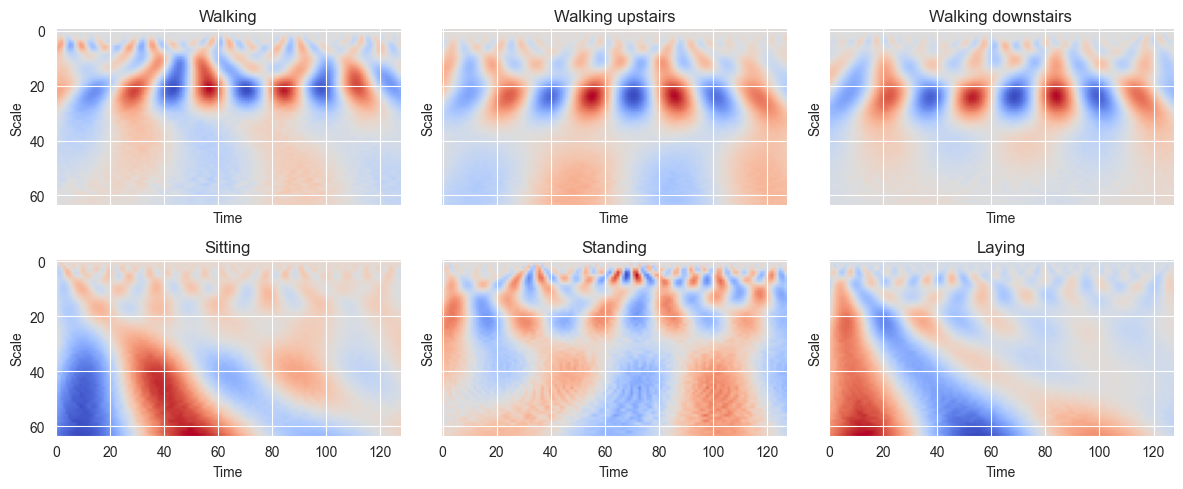

In [7]:
def plot_cwt_coeffs_per_label(X, label_indicies, label_names, signal, sample, scales, wavelet):

    fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12,5))

    for ax, indices, name in zip(axs.flat, label_indicies, label_names):
        coeffs, freqs = pywt.cwt(X[indices[sample],:, signal], scales, wavelet = wavelet)
        ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
        ax.set_title(name)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('Scale')
        ax.set_xlabel('Time')
    plt.tight_layout()

#signal indicies: 0 = body acc x, 1 = body acc y, 2 = body acc z, 3 = body gyro x, 4 = body gyro y, 5 = body gyro z, 6 = total acc x, 7 = total acc y, 8 = total acc z
signal = 3 # signal index
sample = 1 # sample index of each label indicies list
scales = np.arange(1, 65) # range of scales
wavelet = 'morl' # mother wavelet

plot_cwt_coeffs_per_label(X_train, train_labels_indicies, LABEL_NAMES, signal, sample, scales, wavelet)

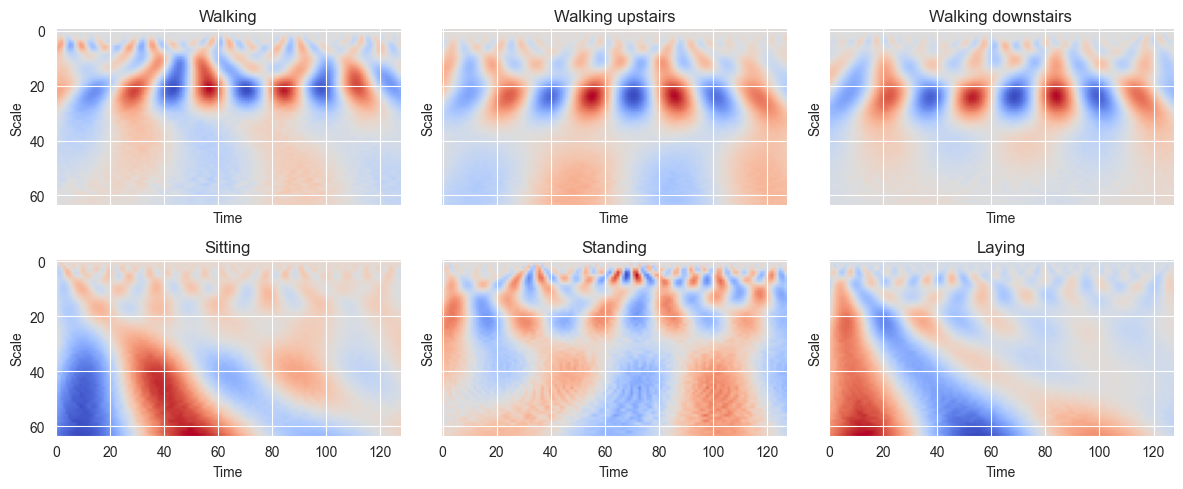

In [8]:

def plot_cwt_coeffs(X, label_indicies, label_names, signal, sample, scales, wavelet):

    fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(12,5))

    for ax, indices in zip(axs.flat, label_indicies):
        coeffs, freqs = pywt.cwt(X[indices[sample],:, signal], scales, wavelet = wavelet)
        ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
        ax.set_title('name')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('Scale')
        ax.set_xlabel('Time')
    plt.tight_layout()

plot_cwt_coeffs_per_label(X_train, train_labels_indicies, LABEL_NAMES, signal, sample, scales, wavelet)


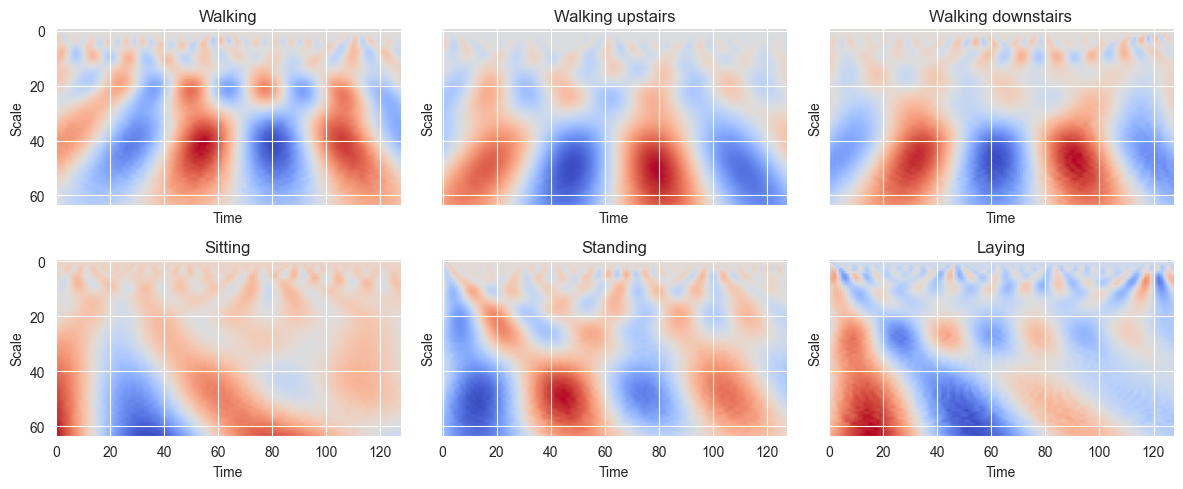

In [9]:
#signal indicies: 0 = body acc x, 1 = body acc y, 2 = body acc z, 3 = body gyro x, 4 = body gyro y, 5 = body gyro z, 6 = total acc x, 7 = total acc y, 8 = total acc z
signal = 8 # signal index
sample = 1 # sample index of each label indicies list
scales = np.arange(1, 65) # range of scales
wavelet = 'morl' # mother wavelet

plot_cwt_coeffs_per_label(X_train, train_labels_indicies, LABEL_NAMES, signal, sample, scales, wavelet)

## Challenge 1

Create a function that will iterate over the dataset to create cwt images

In [10]:
#time is the 2nd vector - 128
#21 people in train, 9 in test
#sensor is 3rd vector 0 = body acc x, 1 = body acc y, 2 = body acc z, 3 = body gyro x, 4 = body gyro y, 5 = body gyro z, 6 = total acc x, 7 = total acc y, 8 = total acc z
print(X_train.shape)

print(train_labels_indicies)


(7352, 128, 9)
[array([  78,   79,   80, ..., 7291, 7292, 7293]), array([ 150,  151,  152, ..., 7349, 7350, 7351]), array([ 125,  126,  127,  128,  129,  130,  131,  132,  133,  134,  135,
        136,  137,  138,  139,  140,  141,  142,  143,  144,  145,  146,
        147,  148,  149,  296,  297,  298,  299,  300,  301,  302,  330,
        331,  332,  333,  334,  335,  336,  337,  338,  339,  340,  341,
        342,  343,  344,  345,  346,  465,  466,  467,  468,  469,  470,
        471,  472,  473,  474,  475,  476,  477,  478,  479,  480,  481,
        482,  483,  484,  485,  486,  487,  637,  638,  639,  640,  641,
        642,  643,  644,  645,  646,  647,  648,  649,  650,  651,  652,
        653,  654,  655,  656,  657,  658,  659,  660,  661,  662,  797,
        798,  799,  800,  801,  802,  803,  804,  805,  806,  807,  808,
        809,  810,  811,  812,  813,  814,  815,  816,  817,  818,  819,
        820,  821,  946,  947,  948,  949,  950,  951,  952,  953,  954,
        

In [11]:
import time
def create_cwt_images(X, n_scales, rescale_size, wavelet_name = "morl"):

    n_samples = X.shape[0] # the number of samples

    n_signals = X.shape[2] # the diff readings
    print(n_samples)
    # range of scales from 1 to n_scales
    scales = np.arange(1, n_scales + 1)

    # pre allocate array
    X_cwt = np.ndarray(shape=(n_samples, rescale_size, rescale_size, n_signals), dtype = 'float32')

    ###YOUR CODE HERE###

    #for datapoint in X[0]
    start_time = time.perf_counter()
    #print(X.shape)
    import cv2
    img_height = rescale_size  # Desired image height
    img_width = rescale_size   # Desired image width
    for value in range(X.shape[0]):



        #print(X[value].shape)
        for sensor in range(X.shape[2]):
            #print(X[value,:,sensor].shape)
            coeffs, freqs = pywt.cwt(X[value,:, signal], scales, wavelet = wavelet)

            resized = cv2.resize(coeffs, (img_height,img_width))
            #plt.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
            #plt.imshow(resized, cmap = 'coolwarm', aspect = 'auto')

            #fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12,5))
            #axs[0].imshow(coeffs, cmap = 'coolwarm', aspect = '1')
            #axs[1].imshow(resized, cmap = 'coolwarm', aspect = '1')
            X_cwt[value,:,:,sensor] = resized
    end_time = time.perf_counter()
    execution_time = end_time - start_time
    average_time = execution_time / X.shape[0]
    print(f"Execution time: {execution_time:.6f} seconds with an average of {average_time:.6f} seconds")

    ### YOUR CODE HERE###


    return X_cwt


In [12]:
### RUN THE FUNCTION TO GENERATE IMAGES

# amount of pixels in X and Y
rescale_size = 64
# determine the max scale size
n_scales = 64

X_train_cwt = create_cwt_images(X_train, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: {X_train_cwt.shape}")
X_test_cwt = create_cwt_images(X_test, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: {X_test_cwt.shape}")

np.save('./Dataset/X_train_cwt.npy', X_train_cwt)
np.save('./Dataset/X_test_cwt.npy', X_test_cwt)



7352
Execution time: 78.856492 seconds with an average of 0.010726 seconds
shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: (7352, 64, 64, 9)
2947
Execution time: 31.335158 seconds with an average of 0.010633 seconds
shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: (2947, 64, 64, 9)


### Important practice

When working with deep learning to any capacity, it is a good habit to keep track of all computational variables. This means things such as total training time, time per epoch, inference time etc. This is especially paramount when working with AI for sustainability as we need to consider computation as a resource. Therefore we want to always ensure we keep track of these values as good practice.

Please observe how this is done in the first challenge, as you will need to apply this to challenge 3 yourself and all future labs and courseworks.

## Challenge 2

Challenge 2 is to build a basic Multi-Layer Perceptron that can try to classify some test images. Keep the model simple to start, and experiment with a few features such as dropout and activations.

In [13]:
X_train_cwt = np.load('./Dataset/X_train_cwt.npy')
X_test_cwt = np.load('./Dataset/X_test_cwt.npy')


In [16]:
X_train_cwt.shape[1:]

(64, 64, 9)

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam

def build_mlp_model(input_shape, num_classes, activation='relu'):

    model = Sequential()

    ###YOUR CODE HERE###

    input_shape = X_train_cwt.shape[1:]
    model = Sequential([
        Input(input_shape),
        Flatten(),
        Dense(1024, activation='relu'),
        #Dense(1024, activation='relu'),
        #Dense(512, activation='relu'),
        #Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')  # Use a single output neuron with a sigmoid activation function for binary classification.
    ])
    # ---------------------------------
    # Display the model architecture to visualise its layers and parameters.
    model.summary()



    ###YOUR CODE HERE###

    # summarize the model
    print(model.summary())
    return model


<details>
  <summary>Hint</summary>

  Remember a MLP is a neural network of stacked linear layers



In [80]:
import time


def compile_and_fit_model(model, X_train, y_train, batch_size, n_epochs):

    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

    # define callbacks
    callbacks = [ModelCheckpoint(filepath='best_model.keras', monitor='val_sparse_categorical_accuracy', save_best_only=True)]

    ### Here we are noting the starting time of training
    start_time = time.time()


    # fit the model
    history = model.fit(x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        verbose=1,
                        callbacks=callbacks,
                        #validation_data=(X_test, y_test)
                        validation_split=0.2
                        )

    ### And here, once the model finishes training we log the time and the difference is the time taken to train the model
    end_time = time.time()
    training_time = end_time - start_time

    return model, history, training_time

In [81]:
# shape of the input images
###Set input shape to the appropriate dimensions
input_shape = (X_train_cwt.shape[1], X_train_cwt.shape[2], X_train_cwt.shape[3])

# create mlp model
mlp_model = build_mlp_model(input_shape, 6, "relu")
# train mlp model
trained_mlp_model, mlp_history, mlp_training_time = compile_and_fit_model(mlp_model, X_train_cwt, y_train, 64, 6)

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1024)           │    37,749,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,755,910 (144.03 MB)

 Trainable params: 37,755,910 (144.03 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1024)           │    37,749,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,755,910 (144.03 MB)

 Trainable params: 37,755,910 (144.03 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 11.6300 - sparse_categorical_accuracy: 0.2121 - val_loss: 7.5369 - val_sparse_categorical_accuracy: 0.3025
Epoch 2/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - loss: 5.1053 - sparse_categorical_accuracy: 0.3743 - val_loss: 3.9455 - val_sparse_categorical_accuracy: 0.3759
Epoch 3/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 3.1420 - sparse_categorical_accuracy: 0.3977 - val_loss: 3.5870 - val_sparse_categorical_accuracy: 0.3732
Epoch 4/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - loss: 2.2853 - sparse_categorical_accuracy: 0.4324 - val_loss: 1.9087 - val_sparse_categorical_accuracy: 0.4276
Epoch 5/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 1.7507 - sparse_categorical_accuracy: 0.4498 - val_loss: 1.5376 - val_sparse_categorical_accuracy: 0.4446
Epoch 6/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 1.5132 - sparse_categorical_accuracy: 0.4767 - val_loss: 1.5432 - val_sparse_categorical_accuracy: 0.418

In [82]:
### USE MODEL TO MAKE PREDICTIONS

trained_mlp_model.evaluate(X_test_cwt,y_test)


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4920 - sparse_categorical_accuracy: 0.4343


[1.496302843093872, 0.4285714328289032]

Now that we have a trained model and have output predictions, we can evaluate the model.

First, let us check the accuracy.

In [83]:
y_test

array([[4],
       [4],
       [4],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [84]:
# DETERMINE THE ACCURACY OF THE MODEL AND PRINT THE VALUE
pred = trained_mlp_model.predict(X_test_cwt)

predicted_class = np.argmax(pred, axis=1)

predicted_class



93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


array([3, 5, 5, ..., 0, 0, 1])

Then, lets plot the training and validation accuracy and loss

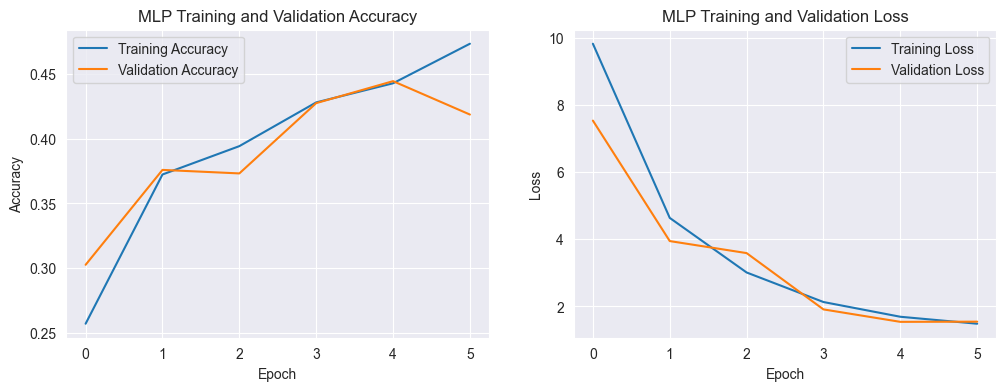

In [85]:
import matplotlib.pyplot as plt
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(mlp_history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(mlp_history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('MLP Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(mlp_history.history['loss'], label='Training Loss')
plt.plot(mlp_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('MLP Training and Validation Loss')

plt.show()


Next, let us generate a confusion matrix to further visualise the predictions

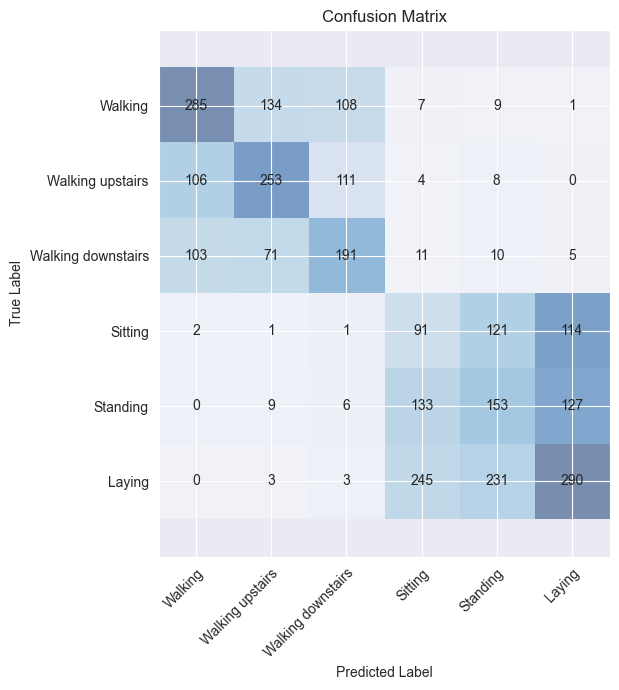

In [86]:
def create_confusion_matrix(y_pred, y_test):
    #calculate the confusion matrix
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(confmat, cmap=plt.cm.Blues, alpha=0.5)

    n_labels = len(LABEL_NAMES)
    ax.set_xticks(np.arange(n_labels))
    ax.set_yticks(np.arange(n_labels))
    ax.set_xticklabels(LABEL_NAMES)
    ax.set_yticklabels(LABEL_NAMES)

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # loop over data dimensions and create text annotations.
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=i, y=j, s=confmat[i, j], va='center', ha='center')

    # avoid that the first and last row cut in half
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    ax.set_title("Confusion Matrix")
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()


create_confusion_matrix(predicted_class, y_test)

Let's also create a classification report

In [70]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted_class, target_names=LABEL_NAMES))

                    precision    recall  f1-score   support

           Walking       0.75      0.55      0.64       496
  Walking upstairs       0.67      0.72      0.69       471
Walking downstairs       0.55      0.70      0.62       420
           Sitting       0.44      0.59      0.50       491
          Standing       0.56      0.59      0.57       532
            Laying       0.98      0.59      0.73       537

          accuracy                           0.62      2947
         macro avg       0.66      0.62      0.63      2947
      weighted avg       0.66      0.62      0.63      2947



And lastly, let us check the inference time of the model. We do this by perfomring inference over every index in test data and averaging the time to best represent the inference time

In [ ]:
inference_times = []
# Perform inference and record times
for i in range(len(X_test_cwt)):
    start_time = time.time()
    _ = trained_mlp_model.predict(np.array([X_test_cwt[i]]), verbose=0)
    end_time = time.time()
    inference_times.append(end_time - start_time)

# Calculate average and standard deviation
avg_time = np.mean(inference_times)
std_time = np.std(inference_times)
print(f"Training Time: {mlp_training_time} s")
print(f'Average Inference Time over {len(X_test_cwt)} runs: {avg_time*1000:.2f} ms')
print(f'Standard Deviation: {std_time*1000:.2f} ms')


## Challenge 3

For challenge 3, instead of a multi-layer perceptron let's build a CNN model for this task

In [ ]:
def build_cnn_model(activation, input_shape):
    model = Sequential()

    ###YOUR CODE HERE###




    ###YOUR CODE HERE###

    # summarize the model
    print(model.summary())

    return model

Next, let us build train the model in the same way we did for the MLP

In [ ]:
###YOUR CODE HERE

Now that you have built and trained the model, let's evaluate the model like how we did in Challenge 2

In [ ]:
###MAKE PREDICTIONS

In [ ]:
###DETERMINE ACCURACY

In [ ]:
###PLOT ACCURACY AND LOSS

In [ ]:
###PLOT CONFUSION MATRIX

In [ ]:
###CLASSIFICATION REPORT

In [ ]:
###INFERENCE TIME ANALYSIS

## Challenge 4 - extra

Now that we have 2 models that have been built and trained on our dataset for this lab, how do they compare with eachother? Which would you use if you were deciding?

In practice we often test more than 2 architectures, as an extra challenge you can try and build a model that is neither a MLP or CNN and see how it compares. Also, you can try to see how the same models would perform without any signal processing whatsoever, or with other types of signal processing techniques - such as Fourier Transform.